<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/05_transfer_learning_in_tensorflow-part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow 2 : Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning : fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sat Jul 17 04:07:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks, we created a bunch of helper functions, now we could rewrite them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download some of the functions we've used previously here : https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-17 04:07:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-17 04:07:19 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note** : If you're running this notebook in Google Colab, when it times out Colab will delete `helper functions`, so you'll have to re-download it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pre-trained models within `tf.keras.applications`  (recognizing images of food)
 link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-17 04:07:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   224MB/s    in 0.7s    

2021-07-17 04:07:22 (224 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many image and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir ="10_food_classes_10_percent/train"
test_dir ="10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

In [8]:
# Preprocess image dataset in a directory https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

IMG_SIZE=(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of batch of data
for images, labels in train_data_10_percent.take(1) :
  print(images, labels)

tf.Tensor(
[[[[202.85715   203.85715   198.85715  ]
   [201.92857   202.92857   197.33163  ]
   [199.20918   200.20918   194.20918  ]
   ...
   [166.0051    162.0051    151.0051   ]
   [165.21428   161.21428   150.21428  ]
   [165.85715   161.85715   150.85715  ]]

  [[208.47449   209.47449   202.28061  ]
   [206.21428   207.21428   199.48979  ]
   [206.34183   207.34183   199.34183  ]
   ...
   [163.14285   159.14285   148.14285  ]
   [164.28572   160.28572   149.28572  ]
   [166.54594   162.54594   151.54594  ]]

  [[190.35204   192.06122   179.56122  ]
   [189.54082   191.31122   178.23979  ]
   [188.66837   190.23979   179.02551  ]
   ...
   [166.16835   162.16835   151.16835  ]
   [165.80103   161.80103   150.80103  ]
   [166.28064   162.28064   151.28064  ]]

  ...

  [[110.70306    72.56538    46.703228 ]
   [184.46396   140.94872   106.90285  ]
   [217.6935    170.31085   126.64257  ]
   ...
   [156.0869    157.65837   156.87263  ]
   [145.60214   147.77055   144.57153  ]
   [1

## Model 0 : Building a transfer learning feature extraction model using the Keras Functional API
The sequential API is straight-forward, it runs our layers in sequential order.
But the functional API gives ur more flexibility with our models -https://www.tensorflow.org/guide/keras/functional

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3) , name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs(Not required for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model : {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D : {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks =[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210717-040733
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 298ms/step - loss: 1.9301 - accuracy: 0.3920 - val_loss: 1.3241 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 5s 204ms/step - loss: 1.1549 - accuracy: 0.7387 - val_loss: 0.9240 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 5s 194ms/step - loss: 0.8567 - accuracy: 0.8027 - val_loss: 0.7789 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 5s 203ms/step - loss: 0.6915 - accuracy: 0.8400 - val_loss: 0.6524 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 5s 207ms/step - loss: 0.5969 - accuracy: 0.8613 - val_loss: 0.6087 - val_accuracy: 0.8388


In [13]:
# Evaulate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 113ms/step - loss: 0.6001 - accuracy: 0.8412


[0.600065290927887, 0.8411999940872192]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers) :
  print (layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


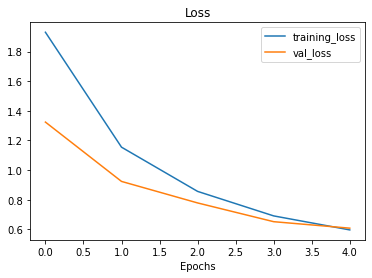

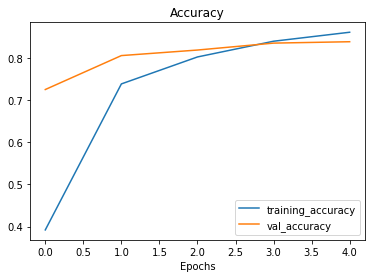

In [17]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a featured vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after out model goes through `base model` of shape (None, 7, 7, 1280)

But when it passes through GlobalAveragePooling2D it turns to (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.



In [18]:
# Define the input shape
input_shape =  (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : \n {input_tensor} \n")

# pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

print(f"2D global average pooled random tensor :\n {global_average_pooled_tensor} \n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooling 2D tensor : {global_average_pooled_tensor.shape}")

Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor :
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooling 2D tensor : (1, 3)


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> **Practice** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

**Note** : One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns our of for our own specific problem.

In [20]:
# Let's try the same with GlobalMaxPool2D

input_shape=(1, 4, 4, 3)

# Create a random tensor 
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor : \n {input_tensor} \n")

# Pass the random tensor to GlobalMaxPool2D
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Global Max Pool tensor : \n {global_max_pool_tensor} \n")

# Compare the shape
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of GlobalMaxPool tensor : {global_max_pool_tensor.shape}")


Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

Global Max Pool tensor : 
 [[0.9058464 1.1603122 1.6994323]] 

Shape of input tensor : (1, 4, 4, 3)
Shape of GlobalMaxPool tensor : (1, 3)


In [21]:
# Let's replicate the GlobalMaxPool2D layer
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

# Running a series of transfer learning experiments
We've seen the incredible results transfer learning can get with only 10% od the training data , but how does it go with 1% of the training data... how about we set up a bunch of experiemnts to find out:


1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 1% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of training data wiht data augmentation

> **Note** : throughtout all experiments the same test dataset will be used to evaluated our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [22]:
# Download and unzip data - preprocessed from Food101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2021-07-17 04:08:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   188MB/s    in 0.7s    

2021-07-17 04:08:52 (188 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Create training and test dir

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [24]:
# How many images we are working with 
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [25]:
# Setup Data Loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into model 
To add data augmentation right into our models, we can use layers inside :
 * `tf.keras.layers.experimental.preprocessing()`


 We can see the benefits of using preprocessing layers for data augmentation 
 https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers


Off the top of heads, after reading the docs, the benefits of data augmentation inside the model are :
* Preprocessing of images (augmenting them) happens on the GPU(much faster) rather than CPU.
*  Image data augmentation happens only during training, so we can still export our whole model and use it elsewhere.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms etc
data_augmentation = keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.2),
            preprocessing.RandomZoom(0.2),
            preprocessing.RandomHeight(0.2),
            preprocessing.RandomWidth(0.2),
            #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's have rescaling built-in
                                                                                     
], name="data_augmentation")

### Visualize our data augmentation layer(and see what happens to our data)

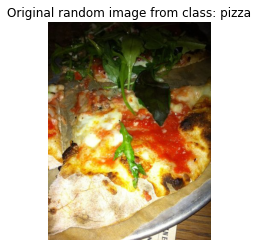

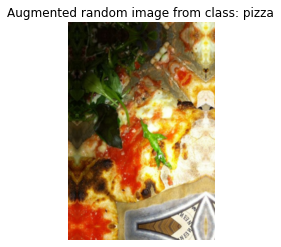

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model_1 : Feature Extraction transfer learning on 1% of the data with data augmentation


In [28]:
# Set up input shape and base model, freezing the base model layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the ouput
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])





Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210717-040857


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4079 - accuracy: 0.0286 - val_loss: 2.2486 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1715 - accuracy: 0.2143 - val_loss: 2.1289 - val_accuracy: 0.2188
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9683 - accuracy: 0.3429 - val_loss: 2.0131 - val_accuracy: 0.3257
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8545 - accuracy: 0.4143 - val_loss: 1.9298 - val_accuracy: 0.3882
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6769 - accuracy: 0.6286 - val_loss: 1.8310 - val_accuracy: 0.4507


In [29]:
# Check model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
# Evaluate on full test data set
results_1_percent_data_aug= model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 1.8221 - accuracy: 0.4600


[1.822145938873291, 0.46000000834465027]

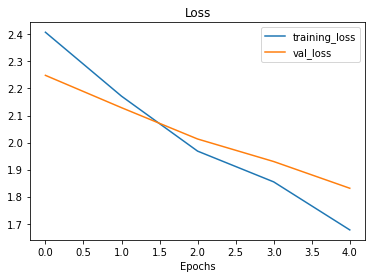

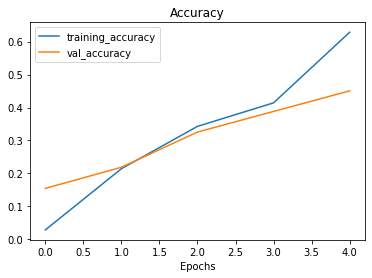

In [31]:
# How do model with 1% of the data augmentation loss curves look
plot_loss_curves(history_1_percent)

## Model 2 : feature extraction transfer learning with 10% of data and data augmentation

In [32]:
# Get 10% of data...(uncomment if you dont have it)
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [33]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [34]:
# Set data inputs
import tensorflow as tf

IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
# Create model_2 with data augmentation built in 
from tensorflow.keras  import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomRotation(0.2),
        # preprocessing.Rescaling(1./255)  #For model such as ResNet50V2, you need to rescale. Efficientnet has rescale built-in                    
], name="data_augmentation")


# Setup input shape to our model
input_shape=(224, 224, 3)

# Create  a frozen base model(also called the backbone)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs(including the layers in between)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs) # augment our training images(augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass the augmented images to base model but keep  it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

#Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])




In [36]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a Model checkpoint call back

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

The ModelCheckpoint callback intermediately saves our model(the full model or just weights) during training.This is useful so we can come and start where we left off.

In [37]:
# Set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves our model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         weights_only=True,
                                                         save_best_only=True , # you can set to false if save weights for all epochs
                                                         save_freq="epoch", # Save eveery epoch
                                                         verbose=1) 

### Fit model2 passing in the ModelCheckpoint callback

In [38]:
# Fit the model saving checkpoints every epoch
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent, 
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210717-040946
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 600ms/step - loss: 2.0035 - accuracy: 0.3467 - val_loss: 1.4520 - val_accuracy: 0.7056

Epoch 00001: val_loss improved from inf to 1.45196, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 2/5
24/24 [==============================] - 10s 421ms/step - loss: 1.3492 - accuracy: 0.6653 - val_loss: 1.0407 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 1.45196 to 1.04074, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 3/5
24/24 [==============================] - 10s 414ms/step - loss: 1.0512 - accuracy: 0.7427 - val_loss: 0.8308 - val_accuracy: 0.7829

Epoch 00003: val_loss improved from 1.04074 to 0.83082, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 4/5
24/24 [==============================] - 10s 383ms/step - loss: 0.8914 - accuracy: 0.7613 - val_loss: 0.7400 - val_accuracy: 0.8043

Epoch 00004: val_loss improved from 0.83082 to 0.74001, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets
Epoch 5/5
24/24 [==============================] - 9s 368ms/step - loss: 0.8070 - accuracy: 0.7800 - val_loss: 0.6644 - val_accuracy: 0.8322

Epoch 00005: val_loss improved from 0.74001 to 0.66439, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ten_percent_model_checkpoints_weights/checkpoint.ckpt/assets


In [39]:
# What were model_0 results?
model_0.evaluate(test_data)


79/79 [==============================] - 9s 106ms/step - loss: 0.6001 - accuracy: 0.8412


[0.6000654101371765, 0.8411999940872192]

In [40]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6872 - accuracy: 0.8192


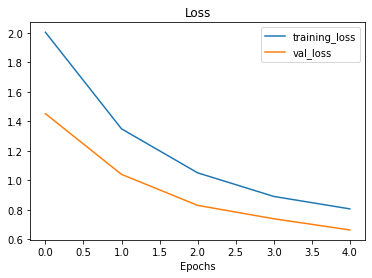

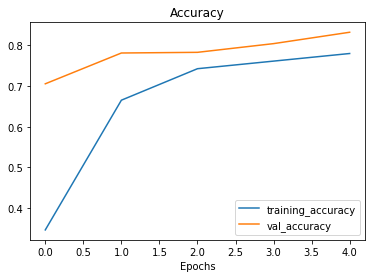

In [41]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

## Loading in checkpointed weights
Loading in checkpointed weight returns a model to a specific checkpoint.



In [44]:
# Load im saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [42]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6872 - accuracy: 0.8192


In [43]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug ==  loaded_weights_model_results

False

In [45]:
results_10_percent_data_aug

[0.6872239708900452, 0.8191999793052673]

In [46]:
loaded_weights_model_results

[0.6872240900993347, 0.8191999793052673]

In [47]:
# Check to see if loaded model results are very close to our previous non-loaded mdoel results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [48]:
# Check the difference between 2 results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3 : Fine-tuning an existing model on 10% of the data

> **Note** : Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [50]:
# Layers in loaed model
model_2.layers

In [51]:
# Are these layers trainable ?
for layer in model_2.layers :
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f104306efd0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f104306e950> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f1042d1c510> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1043067850> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1042d0a3d0> True


In [53]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers) :
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [57]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

10


In [58]:
 # To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable=True
 base_model.trainable = True

 # Freeze all layers except for last 10
 for layer in base_model.layers[:-10] :
   layer.trainable=False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(lr=0.0001), # when fine-tuning, you typically want to lower the learning rate by 10x
                metrics=["accuracy"])


> **Note** : When using fine-tuning it's best practice to lower your learning rate by some amount.
How much? It's a hyperparamter you can tune. But as a good rule of thumb is atleast 10x (though differnt sources will claim other values).

A good resource for information on this is the ULMFiT paper : https://arxiv.org/abs/1801.06146

In [60]:
# Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers) :
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha